*Stanislav Borysov, DTU Management*
# Advanced Business Analytics

## Network Analysis

*Partially based on two Kaggle kernels: [Kernel 1](https://www.kaggle.com/usui113yst/basic-network-analysis-tutorial) and [Kernel 2](https://www.kaggle.com/jamestollefson/enron-network-analysis)*

Welcome to this short introduction on Network Analysis. Today, we will analyze the [Enron email dataset](https://www.cs.cmu.edu/~./enron/) to get insights about the company's communication network.

This dataset was collected and prepared by the CALO Project (A Cognitive Assistant that Learns and Organizes). It contains data from hundreds of employees, mostly senior management of Enron, organized into folders. The corpus contains a total of about 0.5M messages. This data was originally made public, and posted to the web, by the Federal Energy Regulatory Commission during its investigation.

*Background information:*

- https://en.wikipedia.org/wiki/Enron

>Enron Corporation was an American energy, commodities, and services company based in Houston, Texas. It was founded in 1985 as a merger between Houston Natural Gas and InterNorth, both relatively small regional companies. Before its bankruptcy on December 3, 2001, Enron employed approximately 29,000 staff and was a major electricity, natural gas, communications and pulp and paper company, with claimed revenues of nearly 101 billion USD during 2000. Fortune named Enron "America's Most Innovative Company" for six consecutive years.
>
>At the end of 2001, it was revealed that Enron's reported financial condition was sustained by institutionalized, systematic, and creatively planned accounting fraud, known since as the Enron scandal. Enron has since become a well-known example of willful corporate fraud and corruption. The scandal also brought into question the accounting practices and activities of many corporations in the United States and was a factor in the enactment of the Sarbanes–Oxley Act of 2002. The scandal also affected the greater business world by causing the dissolution of the Arthur Andersen accounting firm, which had been Enron's main auditor for years.

- https://en.wikipedia.org/wiki/Enron_scandal

>The Enron Scandal, publicized in October 2001, eventually led to the bankruptcy of the Enron Corporation, an American energy company based in Houston, Texas, and the de facto dissolution of Arthur Andersen, which was one of the five largest audit and accountancy partnerships in the world. In addition to being the largest bankruptcy reorganization in American history at that time, Enron was cited as the biggest audit failure.

This is an extremely rich dataset which has been widely used for many tasks including natural language processing, fraud detection, network analysis and many other. In this notebook, we will use only 20% of the emails and ignore the emails' content except for "To" and "From" fields. Other email attributes such as "REPLY", "FORWARD", "CC", "BCC" are also discarded for simplicity.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('enron_email_ToFrom_20_percent.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99165 entries, 0 to 99164
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   To      99165 non-null  object
 1   From    99165 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [4]:
df.head(20)

,To,From
0,alicia.perkins@enron.com,susan.scott@enron.com
1,chris.germany@enron.com,scott.goodell@enron.com
2,vkaminski@aol.com,vince.kaminski@enron.com
3,patty.donahue@chase.com,benjamin.rogers@enron.com
4,joseph.alamo@enron.com,jeff.dasovich@enron.com
5,bonnie.white@enron.com,richard.sanders@enron.com
6,louis.soldano@enron.com,drew.fossum@enron.com
7,jeff.dasovich@enron.com,mary.lessor@enron.com
8,richard.shapiro@enron.com,sue.nord@enron.com
9,"marie.heard@enron.com, susan.bailey@enron.com",sara.shackleton@enron.com


### 1. NetworkX

Let's have a look at the network (or you can call it a graph) and the basic properties of it. In this Notebook, we use [**NetworkX**](https://networkx.github.io/) as the graph analysis library but there are many more: [igraph](http://igraph.org/redirect.html), [osmnx](https://github.com/gboeing/osmnx) or [SNAP](http://snap.stanford.edu/). NetworkX is one of the most popular Python packages for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

In [5]:
import networkx as nx

*From [Wikipedia](https://en.wikipedia.org/wiki/NetworkX):*

>Features:
>- Classes for graphs and digraphs (directed graphs).
>- Conversion of graphs to and from several formats.
>- Ability to construct random graphs or construct them incrementally.
>- Ability to find subgraphs, cliques, k-cores.
>- Explore adjacency, degree, diameter, radius, center, betweenness, etc.
>- Draw networks in 2D and 3D.
>
>NetworkX is suitable for operation on large real-world graphs: e.g., graphs in excess of 10 million nodes and 100 million edges. Due to its dependence on a pure-Python "dictionary of dictionary" data structure, NetworkX is a reasonably efficient, very scalable, highly portable framework for network and [social network analysis](https://en.wikipedia.org/wiki/Social_network_analysis).

### 2. Email network analysis

A graph $G = (\mathbf{V}, \mathbf{E})$ consists of a set of nodes $\mathbf{V}$ (or vertices) and a set of edges $\mathbf{E}$ (links, connections) which illustrates how the nodes in the network are interacting with each other. Edges can be directed or undirected. The number of nodes $V=|\mathbf{V}|$ is often called the size of the network and states the number of objects in the model. Below, the number of edges is denoted as $E=|\mathbf{E}|$.

Each node or edge can hold different attributes, e.g., nodes can be assigned to different departments within the organisation and edges might have a certain numerical attribute like the number of emails sent between two persons. Edges attributes, in the case of numerical attributes, are called weights. A graph with weighted edges is called a **weighted graph**.

Graph types supported by NetworkX [[link](https://networkx.github.io/documentation/stable/reference/classes/index.html)]:

<div class="wy-table-responsive"><table class="docutils align-default">
<colgroup>
<col style="width: 22%">
<col style="width: 17%">
<col style="width: 28%">
<col style="width: 33%">
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>Networkx Class</p></th>
<th class="head"><p>Type</p></th>
<th class="head"><p>Self-loops allowed</p></th>
<th class="head"><p>Parallel edges allowed</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p>Graph</p></td>
<td><p>undirected</p></td>
<td><p>Yes</p></td>
<td><p>No</p></td>
</tr>
<tr class="row-odd"><td><p>DiGraph</p></td>
<td><p>directed</p></td>
<td><p>Yes</p></td>
<td><p>No</p></td>
</tr>
<tr class="row-even"><td><p>MultiGraph</p></td>
<td><p>undirected</p></td>
<td><p>Yes</p></td>
<td><p>Yes</p></td>
</tr>
<tr class="row-odd"><td><p>MultiDiGraph</p></td>
<td><p>directed</p></td>
<td><p>Yes</p></td>
<td><p>Yes</p></td>
</tr>
</tbody>
</table></div>

Let's define a function to build a directed graph from the data...

In [6]:
def get_digraph_from_df(df_g):
    G = nx.DiGraph() # directed graph
    for index, row in df_g.iterrows():
        sender = row['From']
        recipients = row['To'].split(", ")
        for r in recipients:
            G.add_edge(sender, r)
            # uncomment below to add weights
            """
            if 'weight' not in G[sender][r]:
                G[sender][r]['weight'] = 0
            G[sender][r]['weight'] += 1
            #"""
    return G

...and construct our network

In [7]:
G_full = get_digraph_from_df(df)
print(nx.info(G_full))

Name: 
Type: DiGraph
Number of nodes: 45558
Number of edges: 163157
Average in degree:   3.5813
Average out degree:   3.5813


Using the `nx.info()` function, we can see that the graph has *45558* nodes and *163157* edges, and it is a `DiGraph`, which means the edges of the graph are **directed**, pointing from an email sender to its receivers. A node degree is simply the number of edges it has pointing to other nodes and is discussed below.

#### 2.1. Node degree

The simplest characteristic of a node in the graph is its **degree** (denoted by $k$), which stands for the number of edges it has to other nodes. For directed graphs, we have to distinguish between the **in-degree** (number of inbound links) and the **out-degree** (number of outbound links) of a node. For an undirected graph, we can calculate the **average degree** by the following formula:

$$\overline{k} = \frac{1}{V} \sum_{i = 1}^V k_i = \frac{2E}{V}$$

Similarly, this can be done seperatly for the in- and out-degrees for a directed graph:

$$\overline{k^{in}} = \frac{1}{V} \sum_{i = 1}^V k^{in}_i =\overline{k^{out}} = \frac{1}{V} \sum_{i = 1}^V k^{out}_i =  \frac{E}{V}$$

because 

$$k_i = k^{out}_i  + k^{in}_i$$

According to `nx.info()`, the average in- and out-degrees are *3.5813*. Note that although average in- and out-degrees are always the same, the distribution of the individual degrees can be different as we will see a bit later.

#### 2.2. Visualisation

Proper graph visualization is a task-specific (and often very hard) problem. Although NetworkX provides basic functionality for visualizing graphs [[documentation](https://networkx.github.io/documentation/stable/reference/drawing.html)], its main goal is to enable graph analysis rather than perform sophisticated graph visualization. It is highly recommended to visualize graphs with tools dedicated to that task. Notable examples of dedicated and fully-featured graph visualization tools are [Cytoscape](http://www.cytoscape.org/), [Gephi](https://gephi.org/), [Graphviz](http://www.graphviz.org/) and, for LaTeX typesetting, [PGF/TikZ](https://pgf-tikz.github.io/). To use these and other such tools, you should export your NetworkX graph into a format that can be read by those tools.

*Side note: You can take a look at the network visualisation gallery [here](https://flowingdata.com/category/visualization/network-visualization/), or read some theory behind [here](https://en.wikipedia.org/wiki/Graph_drawing), [here](http://www.mpifg.de/~lk/netvis/onlinepdf/Visualization53aJB2.pdf) or [here](https://cns.iu.edu/docs/publications/2018-NetSci-Zoss.pdf).*

Since visualising all 45,558 nodes and 163,157 edges might be problematic, we will restrict ourselves to a subgraph consisting of 200 emails only.

In [8]:
df_small = df.sample(n=200, random_state=0)
# for debugging purposes, we set random_state to get exactly the same "random" numbers each time we run the function
G_small = get_digraph_from_df(df_small)
print(nx.info(G_small))

Name: 
Type: DiGraph
Number of nodes: 1048
Number of edges: 1174
Average in degree:   1.1202
Average out degree:   1.1202


To visualise a network using Matplotlib, [`nx.draw()` function](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw.html#networkx.drawing.nx_pylab.draw) can be used. To calculate positions of the nodes on a 2D plane, NetworkX has several built-in [layouts](https://networkx.github.io/documentation/stable/reference/drawing.html#module-networkx.drawing.layout). Let's try the most popular [spring_layout](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html#networkx.drawing.layout.spring_layout) based on the [Fruchterman-Reingold force-directed algorithm](https://en.wikipedia.org/wiki/Force-directed_graph_drawing).

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

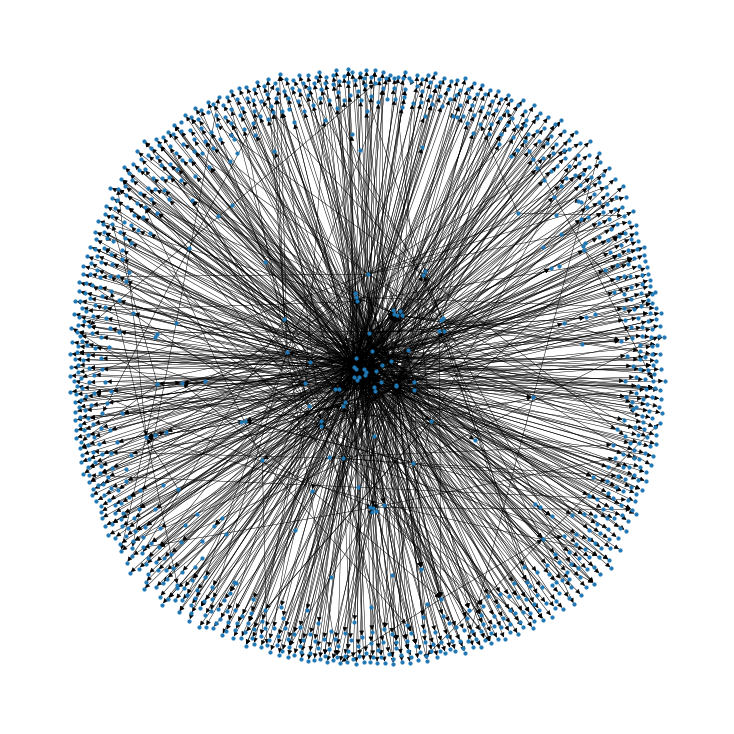

In [10]:
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_small) # calculate positions of the nodes
options = {
    'node_size': 10,
    'width': 0.5,
} # drawing options
nx.draw(G_small, pos=pos, **options)
# equivalent to nx.draw(G_small, pos=pos, node_size=10, width=0.5)
plt.show()

Hmm... it does not look very good. The best visualisation I could get was the one where the node positions are calculated based on an undirected network using `to_undirected()` method and parameter `k=0.1`.

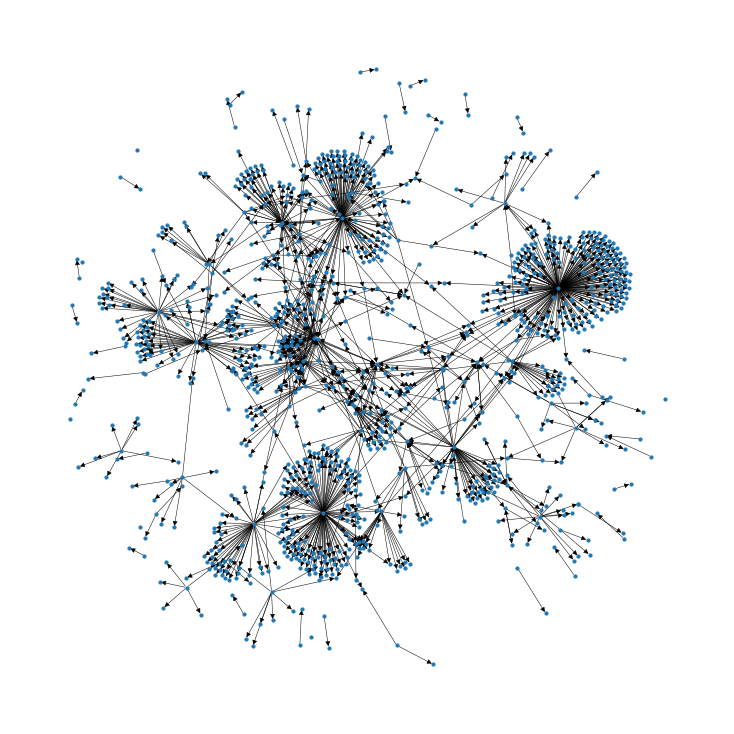

In [11]:
pos = nx.spring_layout(G_small.to_undirected(), k=.1)
plt.figure(figsize=(10, 10))
nx.draw(G_small, pos=pos, **options)
plt.show()

You can experiment a bit with the network visualisation by changing `spring_layout` [parameters](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html#networkx.drawing.layout.spring_layout) or trying other [layouts](https://networkx.github.io/documentation/stable/reference/drawing.html#module-networkx.drawing.layout) such as `circular_layout` or `kamada_kawai_layout`.

*Warning: It might take a while...*

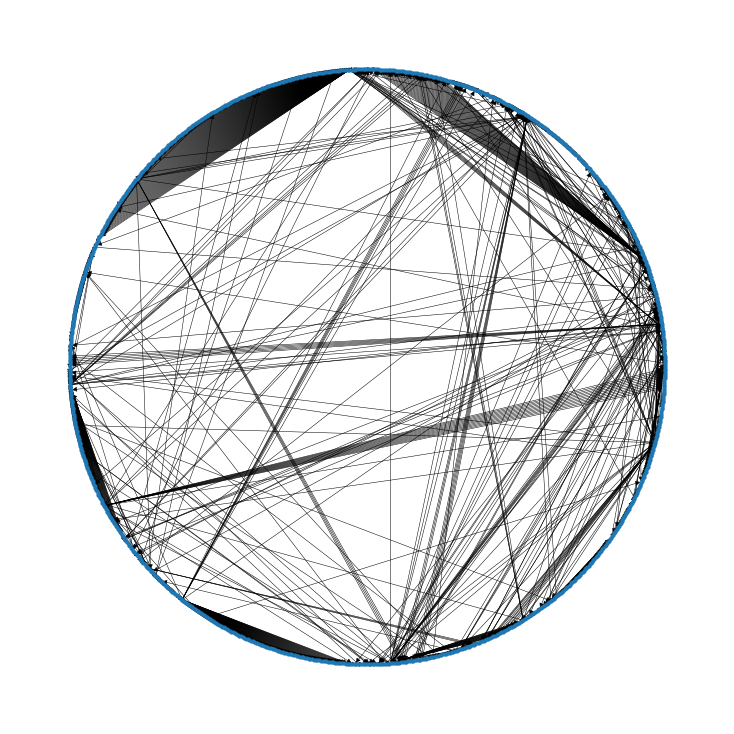

In [12]:
pos = nx.circular_layout(G_small)
plt.figure(figsize=(10, 10))
nx.draw(G_small, pos=pos, **options)
plt.show()

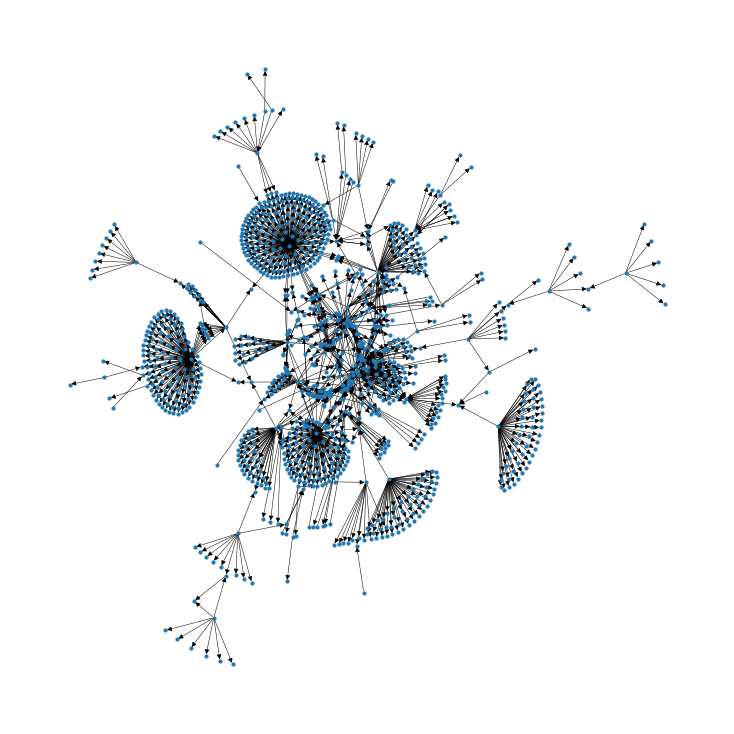

In [13]:
pos = nx.kamada_kawai_layout(G_small.to_undirected())
plt.figure(figsize=(10, 10))
nx.draw(G_small, pos=pos, **options)
plt.show()

Another way to represent (and visualise) networks is the **adjacency matrix**. For an unweighted graph, it is a square ($V\times V$) matrix $\mathbf{A}$, with $A_{ij}=1$ when a node $i$ is connected to a node $j$ and $A_{ij}=0$ otherwise. If the underlying graph is undirected, the matrix is symmetrical.

In [14]:
import seaborn as sns

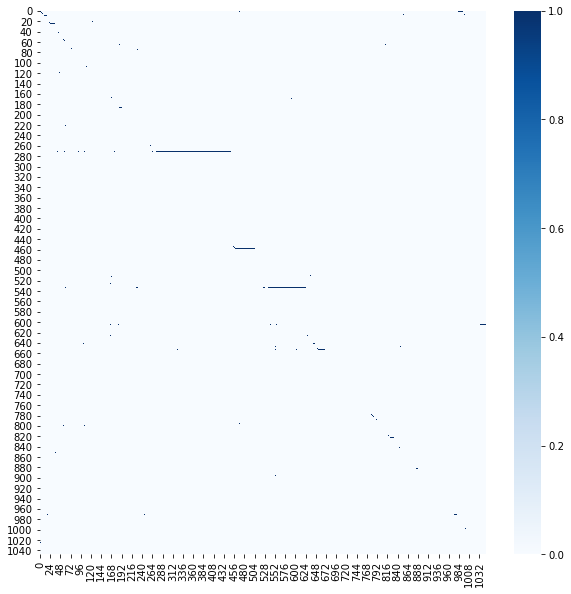

In [15]:
A = nx.to_numpy_matrix(G_small)
plt.figure(figsize=(10, 10))
sns.heatmap(A, cmap=plt.cm.Blues)
plt.show()

From the picture above, it looks like our small network is super-sparse since most elements of $\mathbf{A}$ are zero. Let's calculate the ratio of the number of non-zero elements of $\mathbf{A}$ (the number of edges, $E$) to the maximum number of all theoretically possible non-zero elements, $V_\mathrm{max}=V^2-V=V(V-1)$. Here we assume that the diagonal elements are zero because **self-loops** are not allowed, i.e., the nodes cannot be connected to themselves.

In [40]:
E = A.sum()
#E = len(G_small.edges()) # another way
V = A.shape[0]
#V = len(G_small.nodes()) # another way
V_max = V * (V-1)
print(E / V_max)

0.0010699417455908194


It means that around 99.99% of the matrix elements are zero!

#### 2.3. Network structure properties

Given the number of nodes and edges one can ask, what is the structure of the network and how does it look like?
The simplest measure of the network structure is its **density**, $D$, which measures how many links from all possible links within the network are realized. When the density is *0*, there are no edges and the graph is called **empty graph**. When it is *1*, we have a **complete Graph**, where all possible links between nodes are established.

$$D_{undirected} = \frac{2E}{V(V-1)}$$

$$D_{directed} = \frac{E}{V(V-1)}$$

This is exactly the same quantity as we calculated above.

In [41]:
nx.density(G_small)

0.0010699417455908194

Our full network is even sparser...

In [42]:
nx.density(G_full)

7.861147473441214e-05

We can also calculate some other basic measurements which will give us some information about the structure of the graph.

The **shortest path** (also called geodesic) between two nodes *i* and *j* in the network, *d(i,j)*, as the name suggests, is just the path in the network between nodes *i* and *j* which has the fewest edges. In the case of an undirected network, the shortest path between *i* and *j* is always the same regardless from which node we start. However, in a directed network, this does not hold true and the shortest path between the nodes can vary depending on which node we start. On the bases of the shortest path, we can define many more measurements. For example, the longest shortest path in the network is called the **diameter** of the graph. However, we can calculate these properties only for a **connected graph**.

In [19]:
#nx.diameter(G_small)
# -> NetworkXError: Found infinite path length because the digraph is not strongly connected

In [20]:
#nx.average_shortest_path_length(G_full)
# -> NetworkXError: Graph is not weakly connected.

In a connected graph, every node can be reached (i.e., there is a path) from any other node. If this is not the case, the graph is **disconnected**.

Here, we should also introduce the definition of a **simple graph**, which is a graph without directed edges and self-loops (when a node is connected to itself).  Many graph properties can be calculated for simple graphs only. Also, some of them are computationally demanding.

In [43]:
G_full_simple = G_full.to_undirected()
G_small_simple = G_small.to_undirected()

In [44]:
print(nx.info(G_full_simple))

Name: 
Type: Graph
Number of nodes: 45558
Number of edges: 153876
Average degree:   6.7552


The simple graph has the same number of nodes but a slightly different number of edges. Note that the average degree is not just in- + out-degree because some of the edges were merged.

To address the connectivity problem, we will calculate the above-mentioned metrics for the **giant component** of the network, which is simply the largest connected component (subgraph) in the graph.

In [45]:
#G_full_gc = max(nx.connected_component_subgraphs(G_full_simple), key=len) # will take forever

G_small_gc = max(nx.connected_component_subgraphs(G_small_simple), key=len) 

AttributeError: module 'networkx' has no attribute 'connected_component_subgraphs'

Now, we can calculate its diameter and average shortest path length

In [25]:
nx.diameter(G_small_gc)

NameError: name 'G_small_gc' is not defined

In [ ]:
nx.average_shortest_path_length(G_small_gc)

Interesting, it looks like we have ["6 Handshakes rule"](https://en.wikipedia.org/wiki/Six_degrees_of_separation) in our network.
>Six degrees of separation is the idea that all people are six, or fewer, social connections away from each other. Often called as 6 Handshakes rule. As a result, a chain of "a friend of a friend" statements can be made to connect any two people in a maximum of six steps. It was originally set out by Frigyes Karinthy in 1929 and popularized in an eponymous 1990 play written by John Guare. It is sometimes generalized to the average social distance being logarithmic in the size of the population.

Such a property corresponds to [small-world](https://en.wikipedia.org/wiki/Small-world_network) networks. Let's also check if our network is [scale-free](https://en.wikipedia.org/wiki/Scale-free_network), which is a network whose node degree distribution follows a power law. 

*Hint: The simplest way to do it is to plot the number of nodes (y-axis) versus node degree (x-axis, accending order) using the log scale for both axes (a [log-log plot](https://en.wikipedia.org/wiki/Logarithmic_scale#Graphic_representation)). A power dependancy will manifest as a [straight line](https://en.wikipedia.org/wiki/Logarithmic_scale#/media/File:Logarithmic_Scales.svg).*

In [ ]:
from collections import Counter, OrderedDict

In [ ]:
in_degrees = dict(G_full.in_degree())
in_degrees_counts = Counter(in_degrees.values())
in_degrees_counts_ordered = OrderedDict(sorted(in_degrees_counts.items()))
in_degrees_y = list(in_degrees_counts_ordered.values())
in_degrees_x =list(in_degrees_counts_ordered.keys())
#
out_degrees = dict(G_full.out_degree())
out_degrees_counts = Counter(out_degrees.values())
out_degrees_counts_ordered = OrderedDict(sorted(out_degrees_counts.items()))
out_degrees_y = list(out_degrees_counts_ordered.values())
out_degrees_x =list(out_degrees_counts_ordered.keys())
#
#"""
plt.figure(figsize=(12, 8)) 
plt.loglog(in_degrees_x, in_degrees_y, 'ro-', label="in-degree")
plt.loglog(out_degrees_x, out_degrees_y, 'bo-', label="out-degree")
"""
fig, ax = plt.subplots(figsize=(12, 8)) 
ax.set(xscale="log", yscale="log")
sns.regplot(x=np.log(in_degrees_x), y=np.log(in_degrees_y), ax=ax)
sns.regplot(x=np.log(out_degrees_x), y=np.log(out_degrees_y), ax=ax)
#"""
plt.grid(True)
plt.legend()
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Enron emails')
plt.xlim([0,2*10**2])
plt.show()

Almost straight lines! It means that our network is scale-free.

The scale-free property strongly correlates with the network's robustness to failure. It turns out that the major hubs (nodes with a high degree) are closely followed by smaller ones. These smaller hubs, in turn, are followed by other nodes with an even smaller degree and so on. This hierarchy allows for a fault tolerant behavior. If failures occur at random and the vast majority of nodes are those with small degree, the likelihood that a hub would be affected is almost negligible. Even if a hub-failure occurs, the network will generally not lose its connectedness, due to the remaining hubs. On the other hand, if we choose a few major hubs and take them out of the network, the network is turned into a set of rather isolated graphs. Thus, hubs are both a strength and a weakness of scale-free networks. [[source]](https://en.wikipedia.org/wiki/Scale-free_network#Characteristics)

Although scale-free networks are resilient to random failures, we might imagine them being quite vulnerable to targeted hub removal. In this case we consider the robustness of scale free networks in response to targeted attacks, performed with thorough prior knowledge of the network topology. [[source]](https://en.wikipedia.org/wiki/Robustness_of_complex_networks#Targeted_attacks_on_scale-free_networks)

A few examples of networks claimed to be scale-free include [[source]](https://en.wikipedia.org/wiki/Scale-free_network#Examples):
- Social networks, including collaboration networks. Two examples that have been studied extensively are the collaboration of movie actors in films and the co-authorship by mathematicians of papers.
- Many kinds of computer networks, including the internet and the webgraph of the World Wide Web.
- Software dependency graphs.
- Some financial networks such as interbank payment networks.
- Protein-protein interaction networks.
- Semantic networks.
- Airline networks.

#### 2.4. Node "importance" measures: Centrality

In graph theory and network analysis, indicators of centrality identify the most important vertices within a graph. Applications include identifying the most influential person(s) in a social network, key infrastructure nodes in the Internet or urban networks, and super-spreaders of disease [[source](https://en.wikipedia.org/wiki/Centrality)]. There are many centrality measures such as degree centrality, closeness centrality, betweenness centrality, eigenvector centrality, PageRank centrality, and many others (also implemented in NetworkX, [link1](https://networkx.github.io/documentation/stable/reference/algorithms/centrality.html) and [link2](https://networkx.github.io/documentation/stable/reference/algorithms/link_analysis.html)). In this exercise, we will consider the two most basic ones — degree centrality and betweenness centrality.

*Side note: The PageRank algorithm was developed by the Google founders Larry Page and Sergey Brin at Stanford University in 1996 as part of a research project about a new kind of search engine. This algorithm gave rise to the Google company.*

**Degree centrality**

Historically, the first and conceptually simplest centrality measure is degree centrality, which is defined as the number of links incident upon a node (i.e., the number of ties that a node has). It is equivalent to the node degree used earlier in this notebook normalised by the maximum theoretically possible degree for a node. The degree can be interpreted in terms of the immediate risk of a node for catching whatever is flowing through the network (such as a virus, or some information). In the case of a directed network (where ties have direction), we usually define two separate measures of degree centrality, namely indegree and outdegree. Accordingly, indegree is a count of the number of ties directed to the node and outdegree is the number of ties that the node directs to others. When ties are associated with some positive aspects such as friendship or collaboration, indegree is often interpreted as a form of popularity, and outdegree as gregariousness. [[source]](https://en.wikipedia.org/wiki/Centrality#Degree_centrality)

In [26]:
import numpy as np

In [34]:
# The only difference between nx.degree_centrality(G) and G.degree() 
# is that the former is normalised by the number of nodes - 1
print("Average degree centrality =", 
      np.mean(list(nx.degree_centrality(G_full).values())) * (len(G_full.nodes())-1))
print("Average node degree =", 
      np.mean(list(dict(G_full.degree()).values())))
# The same is true for the in- and out-degrees

Average degree centrality = 7.162605908951226
Average node degree = 7.162605908951227


Let's find the nodes with the highest degree centrality.

In [35]:
def get_top_centrality(G, func, top_n=10):
    degree_cent = func(G)
    degree_cent_ordered = OrderedDict(sorted(degree_cent.items(), 
                                             reverse=True, 
                                             key=lambda x: x[1])[:top_n])
    return degree_cent_ordered

In [36]:
# Top people by degree centrality
dc_cent = get_top_centrality(G_full, nx.degree_centrality)
dc_cent

NameError: name 'OrderedDict' is not defined

In [37]:
# Top people by in-degree (receiving emails from many people)
dc_in_cent = get_top_centrality(G_full, nx.in_degree_centrality)
dc_in_cent

NameError: name 'OrderedDict' is not defined

In [38]:
# Top people by out-degree (sending emails to many people)
dc_out_cent = get_top_centrality(G_full, nx.out_degree_centrality)
dc_out_cent

NameError: name 'OrderedDict' is not defined

By quick search on the Internet, we can see that the most influential people have high centrality degree and out-centrality degree.

- **david.forster@enron.com**  
https://www.linkedin.com/in/david-forster-9b8ba211/  
Vice President. Worked in various management positions in North America and Great Britain, including energy retail, risk management, gas control, origination and trading, including online trading.

- **kenneth.lay@enron.com**  
https://en.wikipedia.org/wiki/Kenneth_Lay  
Kenneth Lee Lay (April 15, 1942 – July 5, 2006) was the founder, CEO and Chairman of Enron and was heavily involved in the Enron scandal, a major accounting scandal that unraveled in 2000 in the largest bankruptcy ever to that date.

- **jeff.skilling@enron.com**  
https://en.wikipedia.org/wiki/Jeffrey_Skilling  
Jeffrey Keith Skilling (born November 25, 1953) is a former American businessman and convicted felon best known as the CEO of Enron Corporation during the Enron scandal. In 2006, he was convicted of federal felony charges relating to Enron's collapse and eventually sentenced to 24 years in prison. The Supreme Court of the United States heard arguments in the appeal of the case March 1, 2010.On June 24, 2010, the Supreme Court vacated part of Skilling's conviction and transferred the case back to the lower court for resentencing.

- **sally.beck@enron.com**  
https://www.linkedin.com/in/sally-beck-96945115/  
Managing Director.

**Betweeness centrality**

Betweenness Centrality defines the fraction of all shortest paths in the network passing through the edge/node for which it is calculated. People with a very high betweenness centrality lie on many shortest paths in the network and should be considered to be important people in the network which may have increased information volume. 

Its calculation for the full graph can take a while. We will compute it for the small graph only.

In [39]:
bc_cent = get_top_centrality(G_small, nx.betweenness_centrality)
bc_cent

NameError: name 'OrderedDict' is not defined

Let's plot the graph with the betweenness centrality to highlight the importance of the nodes.

In [ ]:
bc_cent_all = get_top_centrality(G_small, nx.betweenness_centrality, len(G_small.nodes()))

In [ ]:
pos = nx.spring_layout(G_small.to_undirected(), k=.1)

In [ ]:
nodelist = list(bc_cent_all.keys())
node_size = [v for v in bc_cent_all.values()]
bc_max = node_size[0]
node_size = [1000 * v / bc_max + 10 if v > 0 else 1 for v in node_size]

In [ ]:
plt.figure(figsize=(10, 10))
nx.draw(G_small, pos=pos, width=0.5,
    nodelist=nodelist, node_size=node_size
)
plt.show()

We can see that the nodes in the "middle" have high betweenness centrality and not the nodes with just many connections.

There are many studies analysing the node importance in the Enron network, for example:
- https://cambridge-intelligence.com/using-social-network-analysis-measures/
- http://web.cs.mun.ca/~banzhaf/papers/Enron_CEC2009_IEEE.pdf
- https://academiccommons.columbia.edu/doi/10.7916/D83F4XJ9

- https://scholar.google.se/scholar?hl=en&as_sdt=0%2C5&q=enron+email+network&btnG=